In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
from tqdm.autonotebook import tqdm, trange
import time as time
import copy

In [3]:
data_dir = '/kaggle/input/movie-images-by-types-of-shooting-plans/data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
IMAGE_SIZE = 384
LEARNING_RATE = 3e-4
NORMILIZE_STATISTICS = {'mean': np.array([0.485, 0.456, 0.406]),
                        'std': np.array([0.229, 0.224, 0.225])}
NUM_WORKERS = int(0.8 * os.cpu_count())
RS = 42

In [5]:
torch.manual_seed(RS)

In [6]:
data_transforms = {
    'validation': v2.Compose([
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ToTensor(),
        v2.Normalize(**NORMILIZE_STATISTICS)
    ]),
    
    'training': v2.Compose([
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ToTensor(),
        v2.Normalize(**NORMILIZE_STATISTICS)
    ]),
}

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])for x in ['training', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation']}
class_names = image_datasets['training'].classes

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = NORMILIZE_STATISTICS['std'] * inp + NORMILIZE_STATISTICS['mean']
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(30, 20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [9]:
BATCH_SIZE = 32
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=BATCH_SIZE,
                                              shuffle=True if x == 'training' else False,
                                              num_workers=NUM_WORKERS,
                                              drop_last=True) for x in ['training', 'validation']}

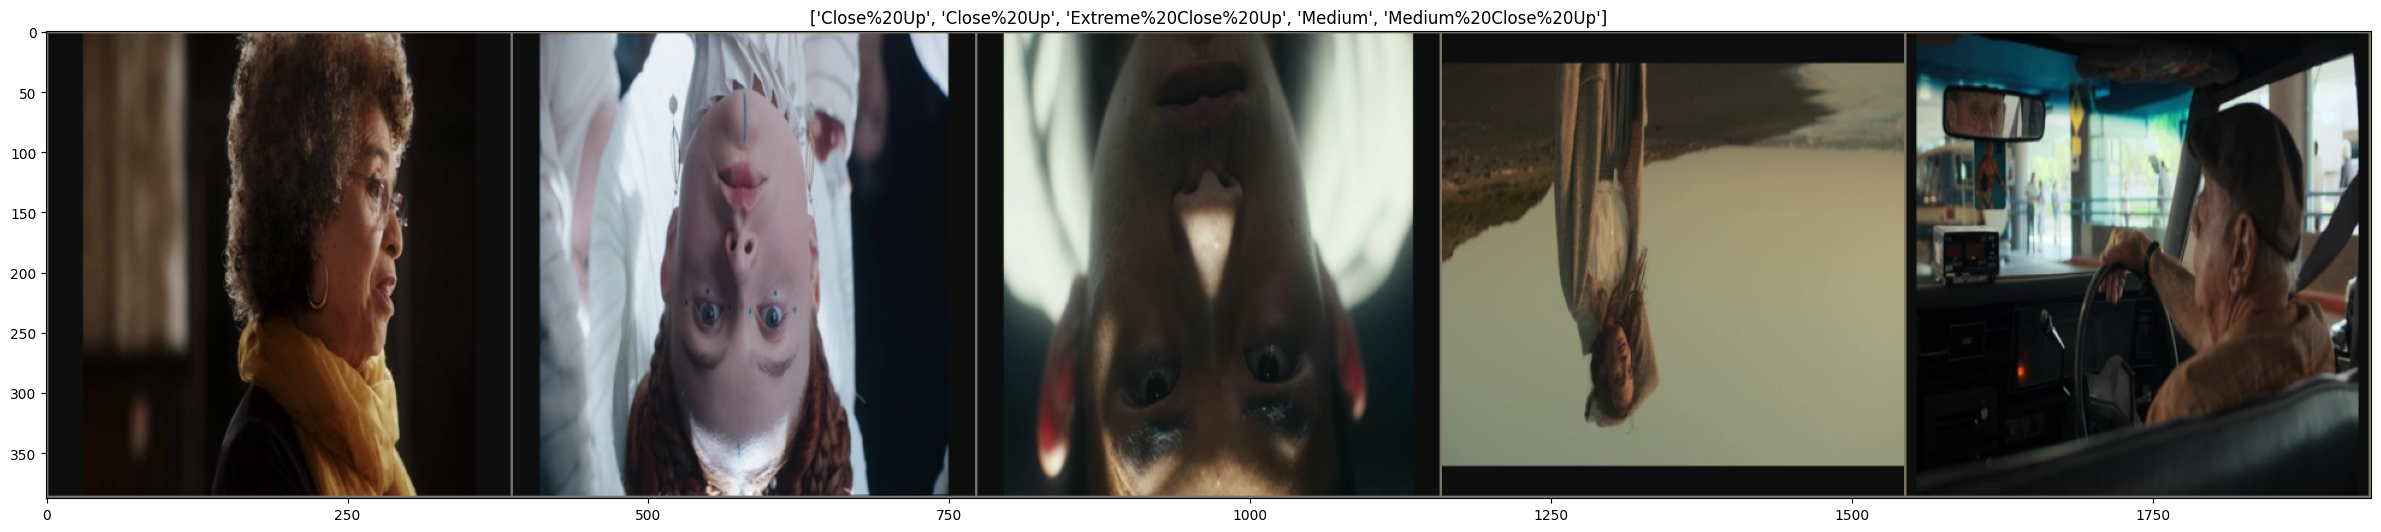

In [10]:
img_n = 5
inputs, classes = next(iter(dataloaders['training']))
outputs = torchvision.utils.make_grid(inputs[:img_n])
imshow(outputs, title=[class_names[x] for x in classes[:img_n]])

In [11]:
def train_model(model,
                criterion,
                optimizer,
                scheduler,
                current_epoch:int = 0,
                save_progress:bool=True,
                save_directory: str='/kaggle/working/model_progress/model_states',
                num_epochs:int=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'training': [], "validation": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # инициализируем градиенты параметров
                if phase=="training":
                    optimizer.zero_grad()

                # forward pass
                if phase == "validation":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'training':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))
            
            #делаем шаг шедулера
            scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_progress:
                    torch.save({
                                'epoch': current_epoch + epoch,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict(),
                                'val_loss': epoch_loss,
                                }, f"checkpoint_{current_epoch + epoch}.pt")
        plt.figure(figsize=(12, 8))
        plt.plot(losses['training'], label="training")
        plt.plot(losses['validation'], label="validation")
        plt.legend()
        plt.show()    
    
    
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [12]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['validation']:
        # получаем картинки и метки
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['validation']

In [16]:
model = torchvision.models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.DEFAULT')

for param in model.parameters():
    param.requires_grad = False

for param in model.features[-3:].parameters():
    param.requires_grad = True

model.classifier = nn.Sequential(
  nn.Dropout(p=0.3, inplace=True),
  nn.Linear(in_features=1280, out_features=7, bias=True)
)

model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.features[-3:].parameters()) + list(model.classifier.parameters()),
                             lr=LEARNING_RATE,
                            )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

Epoch::   0%|          | 0/4 [00:00<?, ?it/s]

training iter::   0%|          | 0/1388 [00:00<?, ?it/s]

validation iter::   0%|          | 0/154 [00:00<?, ?it/s]

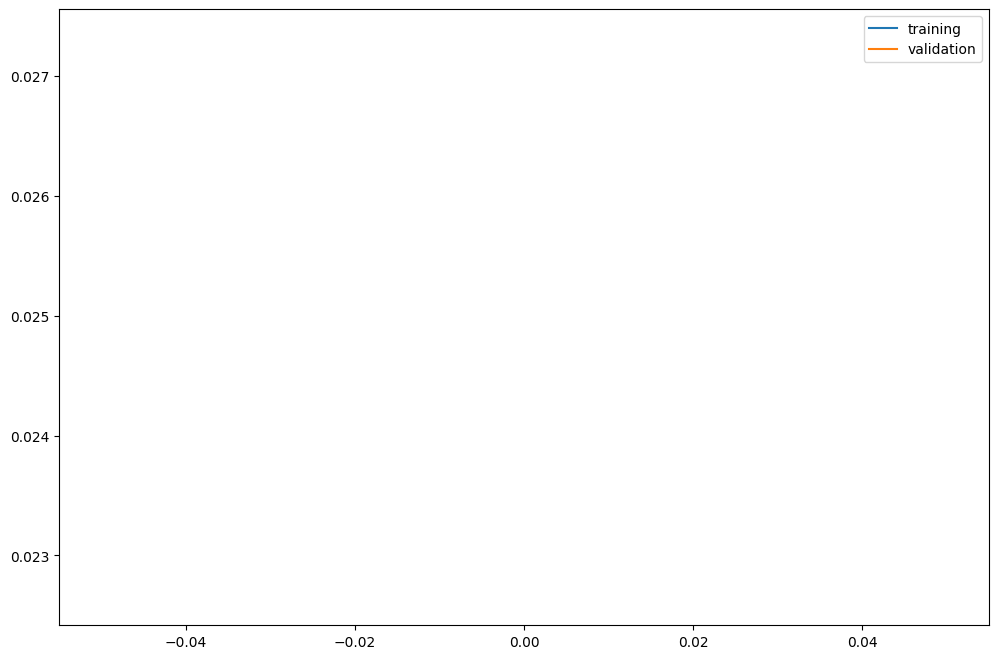

training iter::   0%|          | 0/1388 [00:00<?, ?it/s]

validation iter::   0%|          | 0/154 [00:00<?, ?it/s]

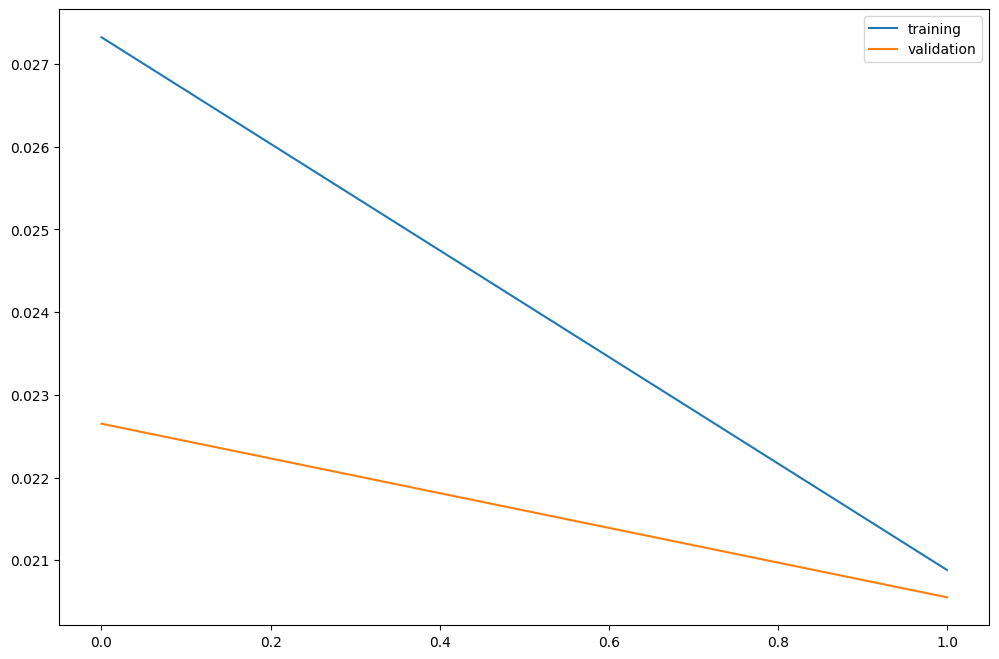

training iter::   0%|          | 0/1388 [00:00<?, ?it/s]

validation iter::   0%|          | 0/154 [00:00<?, ?it/s]

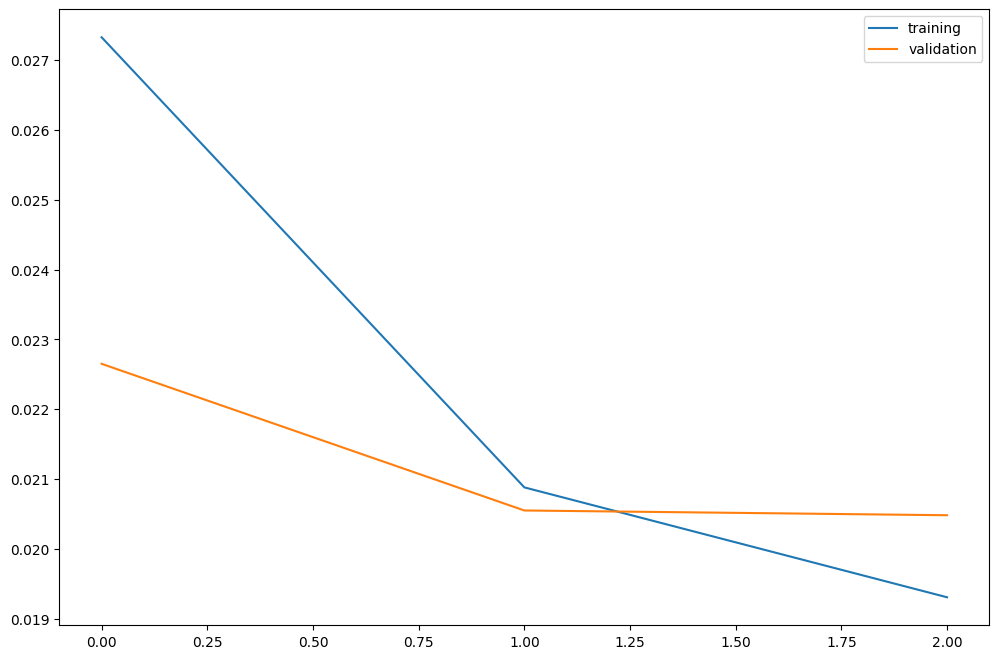

training iter::   0%|          | 0/1388 [00:00<?, ?it/s]

validation iter::   0%|          | 0/154 [00:00<?, ?it/s]

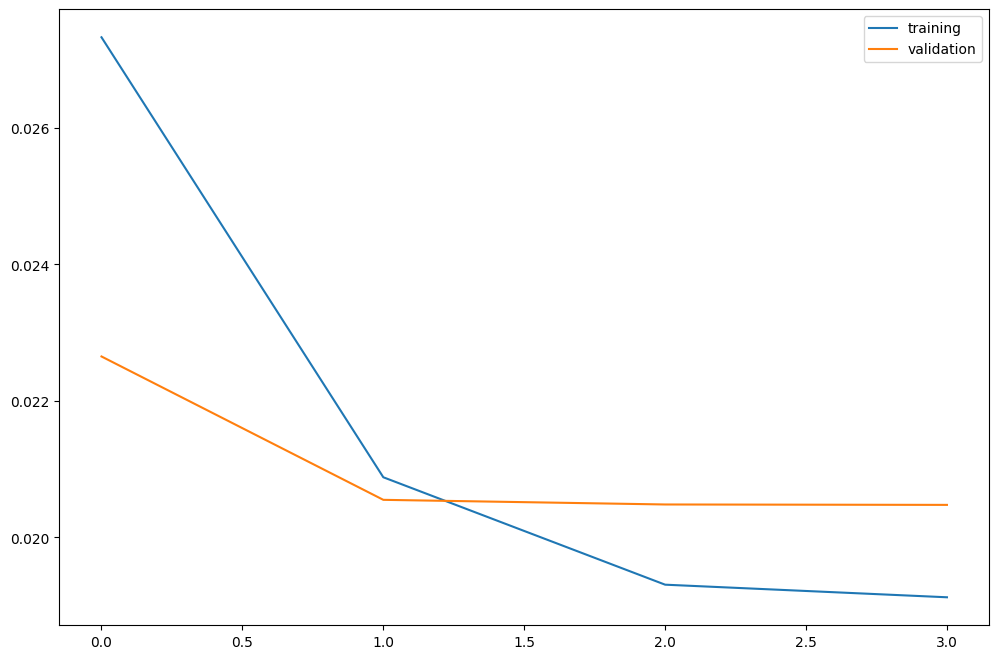

Training complete in 47m 44s
Best val Acc: 0.731401


In [17]:
model, losses = train_model(model, loss, optimizer, scheduler, num_epochs=4)

In [18]:
torch.save(model, 'model\model_7314.pth')